## Import libraries and load data

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch

In [21]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

out = np.load('disc-benchmark-files/training-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('disc-benchmark-files/test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros

cuda


## Visualize data

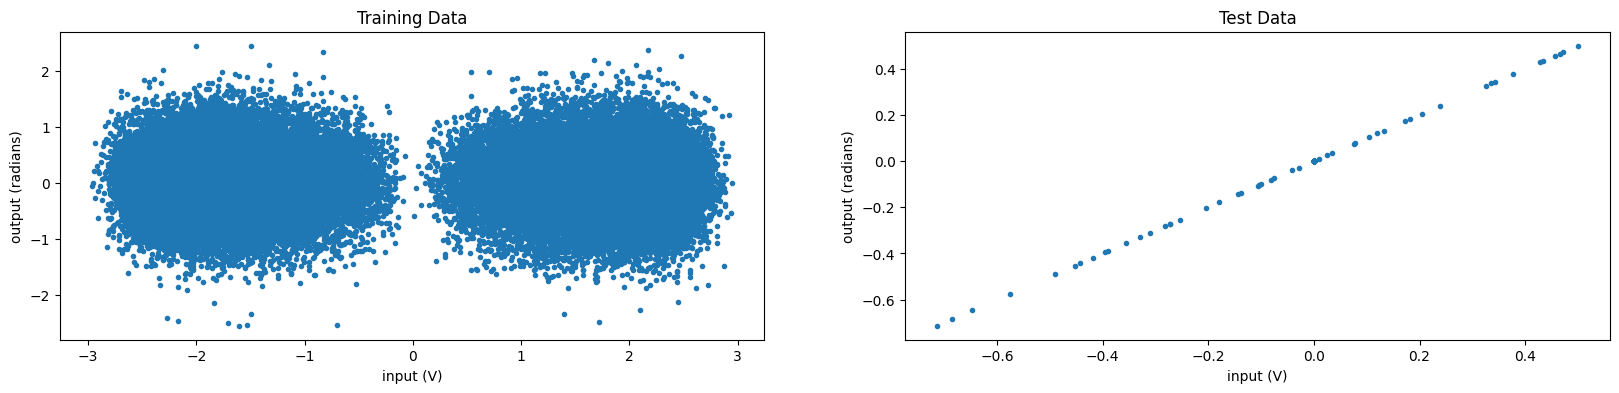

In [22]:
# Plotting the data
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(u_train,th_train,'.')
plt.xlabel('input (V)')
plt.ylabel('output (radians)')
plt.title('Training Data')
plt.subplot(1,2,2)
plt.plot(th_test,th_test,'.')
plt.xlabel('input (V)')
plt.ylabel('output (radians)')
plt.title('Test Data')
plt.show()

## 1. ANN

In [23]:
def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

In [24]:
class Network(nn.Module): 
    def __init__(self, n_in, n_hidden_nodes): 
        super(Network,self).__init__() 
        self.lay1 = nn.Linear(n_in,n_hidden_nodes)
        self.lay2 = nn.Linear(n_hidden_nodes,1)
    def forward(self,x): 
        x1 = torch.relu(self.lay1(x)) 
        y = self.lay2(x1)[:,0] 
        return y 

def train(model,optimizer,criterion,epochs,Xtrain,Ytrain,Xval,Yval):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train()
    train_loss = []
    val_loss =[]
    for epoch in range(epochs):
        Ypred = model(Xtrain.to(device=device))
        loss_train = criterion(Ypred.to(device=device),Ytrain.to(device=device))
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        train_loss.append(loss_train.item())

        with torch.no_grad():
            model.eval()
            Ypred = model(Xval.to(device=device))
            loss_val = criterion(Ypred.to(device=device), Yval)
            val_loss.append(loss_val.item())

        if (epoch+1)%200 == 0:
            print(f'epoch = {epoch+1}, Train_loss = {loss_train.item(): .4f}, Val_loss = {loss_val.item(): .4f}')
    return train_loss, val_loss 

In [27]:
Xdata, Ydata = create_IO_data(u_train,th_train,2,1) # For training data
Xtest, Ytest = create_IO_data(u_test, th_test, 2,1)    # For simulation data

Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata,Ydata)

device="cuda" if torch.cuda.is_available() else "cpu"

Xtrain, Xval, Ytrain, Yval = [torch.as_tensor(x).to(device=device, dtype=torch.float64) for x in [Xtrain, Xval, Ytrain, Yval]]
Xtest, Ytest = [torch.as_tensor(x).to(device=device, dtype=torch.float64) for x in [Xtest, Ytest]]

# model = NARX_NN(Xtrain.shape[1],32,16).to(device=device)
model = Network(Xtrain.shape[1],32).to(device=device, dtype=torch.float64)
learning_rate = 2e-3
optimizer, criterion = torch.optim.Adam(model.parameters(), lr=learning_rate), nn.MSELoss()
train_loss, val_loss = train(model, optimizer, criterion, 10000, Xtrain, Ytrain, Xval, Yval)
torch.save(model.state_dict(), "ANN.pth")    # Saving the best model

epoch = 200, Train_loss =  0.0051, Val_loss =  0.0049
epoch = 400, Train_loss =  0.0003, Val_loss =  0.0003
epoch = 600, Train_loss =  0.0002, Val_loss =  0.0002
epoch = 800, Train_loss =  0.0002, Val_loss =  0.0002
epoch = 1000, Train_loss =  0.0002, Val_loss =  0.0002
epoch = 1200, Train_loss =  0.0002, Val_loss =  0.0002
epoch = 1400, Train_loss =  0.0002, Val_loss =  0.0001
epoch = 1600, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 1800, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 2000, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 2200, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 2400, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 2600, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 2800, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 3000, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 3200, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 3400, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 3600, Train_loss =  0.0001, Val_loss =  0.0001
epoch = 3800, 

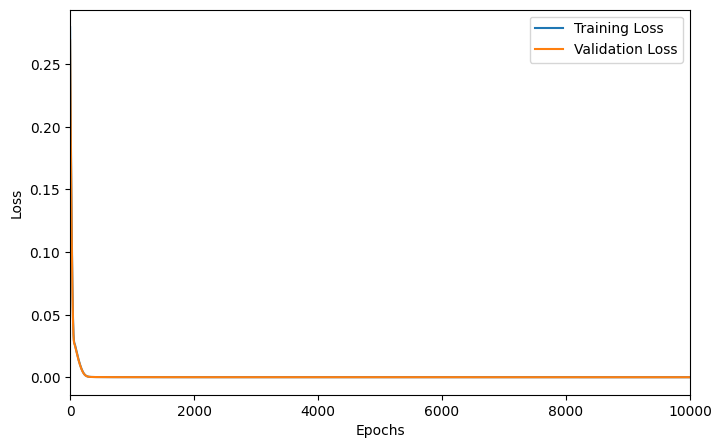

In [28]:
# Plotting the training and validation loss
plt.figure(figsize=(8,5)) 
plt.plot(np.linspace(1,10000,num=10000), train_loss, label="Training Loss") 
plt.plot(np.linspace(1,10000,num=10000), val_loss, label="Validation Loss") 
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.xlim(left=0, right=10001)
plt.show() 